# Simple Weighted Attention Mechanism

We will now implement a simple attention mechanism with trainable weights. Like before, we will first start with a `torch` implementation, and then we'll see how we can express the same operations with `ttnn`.




## Dependencies

Let's import `torch`, and bring back our sample context.

In [1]:
import torch

torch.manual_seed(123)

context = torch.tensor(
  [[0.43, 0.15, 0.89], # Your     (x^1)
   [0.55, 0.87, 0.66], # journey  (x^2)
   [0.57, 0.85, 0.64], # starts   (x^3)
   [0.22, 0.58, 0.33], # with     (x^4)
   [0.77, 0.25, 0.10], # one      (x^5)
   [0.05, 0.80, 0.55]] # step     (x^6)
)

context.shape

torch.Size([6, 3])

## Weight Matrices

We will now need to create the trainable weight matrices:
1. W_query
2. W_key
3. W_value

These are just normal tensors with (d_in, d_out) dimensions. What is d? That is the Dth dimension.

In [2]:
d = context[0].shape
d

torch.Size([3])

Why is d_out less than d_in? Refer to the book to find out why. It seems to be arbitrary and just used for ease in calculation. We can totally increase the dimension.

In [6]:
d_in = d[0]
d_out = d[0] - 1

d_in, d_out

(3, 2)

Initialize the weight matrices with random values.

In [7]:
W_query = torch.rand(d_in, d_out)
W_key = torch.rand(d_in, d_out)
W_value = torch.rand(d_in, d_out)

W_query, W_key, W_value

(tensor([[0.2961, 0.5166],
         [0.2517, 0.6886],
         [0.0740, 0.8665]]),
 tensor([[0.1366, 0.1025],
         [0.1841, 0.7264],
         [0.3153, 0.6871]]),
 tensor([[0.0756, 0.1966],
         [0.3164, 0.4017],
         [0.1186, 0.8274]]))

The query vector is acquired through a matrix multiplication of the embedding of a token in the context vector with the weight matrix.

In [14]:
query_2 = context[1] @ W_query
query_2


TracedTorchTensor([1.3730, 1.5279])

In [11]:
key_2 = context[1] @ W_key
value_2 = context[1] @ W_value

key_2, value_2

(tensor([0.4433, 1.1419]), tensor([0.3951, 1.0037]))

In [12]:
keys = context @ W_key
values = context @ W_value

keys, values

(tensor([[0.3669, 0.7646],
         [0.4433, 1.1419],
         [0.4361, 1.1156],
         [0.2408, 0.6706],
         [0.1827, 0.3292],
         [0.3275, 0.9642]]),
 tensor([[0.1855, 0.8812],
         [0.3951, 1.0037],
         [0.3879, 0.9831],
         [0.2393, 0.5493],
         [0.1492, 0.3346],
         [0.3221, 0.7863]]))

In [13]:
attention_scores_2 = query_2 @ keys.T
attention_scores_2

tensor([1.2705, 1.8524, 1.8111, 1.0795, 0.5577, 1.5440])

In [15]:
d_k = keys.shape[-1]

# scale to avoid vanishing gradients - basically making each number a little bigger than what they are if it is super small
attention_weights_2 = torch.softmax(attention_scores_2 / d_k**0.5, dim=-1)
attention_weights_2

tensor([0.1500, 0.2264, 0.2199, 0.1311, 0.0906, 0.1820])

In [17]:
context_vec_2 = attention_weights_2 @ values
context_vec_2

tensor([0.3061, 0.8210])

In [18]:
keys = context @ W_key
queries = context @ W_query
values = context @ W_value

attention_scores = queries @ keys.T
attention_weights = torch.softmax(attention_scores / d_k**0.5, dim=-1)
context_vec = attention_weights @ values

context_vec


tensor([[0.2996, 0.8053],
        [0.3061, 0.8210],
        [0.3058, 0.8203],
        [0.2948, 0.7939],
        [0.2927, 0.7891],
        [0.2990, 0.8040]])

# ttnn Implementation

Now, let's do the same thing with `ttnn`

## Dependencies

Set up the environment variables, and import the necessary dependencies.

In [7]:
import os
os.environ["TTNN_CONFIG_OVERRIDES"] = "{\"enable_fast_runtime_mode\": false}"

Just like before we'll import the required modules and create a test context to operate with. It just represents a sentence for our LLM.

In [ ]:
import torch
import ttnn
from ttnn.tracer import trace, visualize

torch.manual_seed(123)

context = torch.tensor(
  [[0.43, 0.15, 0.89], # Your     (x^1)
   [0.55, 0.87, 0.66], # journey  (x^2)
   [0.57, 0.85, 0.64], # starts   (x^3)
   [0.22, 0.58, 0.33], # with     (x^4)
   [0.77, 0.25, 0.10], # one      (x^5)
   [0.05, 0.80, 0.55]] # step     (x^6)
)

context.shape

torch.Size([6, 3])

Let's create the query, key and value weight matrices in `torch`, and then we can create tiled versions with `ttnn` with those matrices.

Initializing them with `TILE_LAYOUT` will help us with just calling `matmul` without any additional layout reshaping.

In [13]:
d = context[0].shape
d_in = d[0]
d_out = d[0] - 1

with trace():
  context_ttnn = ttnn.from_torch(context, dtype=ttnn.bfloat16, layout=ttnn.TILE_LAYOUT)

  W_query = torch.rand(d_in, d_out)
  W_key = torch.rand(d_in, d_out)
  W_value = torch.rand(d_in, d_out)

  W_query_ttnn = ttnn.from_torch(W_query, dtype=ttnn.bfloat16, layout=ttnn.TILE_LAYOUT)
  W_key_ttnn = ttnn.from_torch(W_key, dtype=ttnn.bfloat16, layout=ttnn.TILE_LAYOUT)
  W_value_ttnn = ttnn.from_torch(W_value, dtype=ttnn.bfloat16, layout=ttnn.TILE_LAYOUT)

W_query_ttnn, W_key_ttnn, W_value_ttnn

                 Always | INFO     | Begin op: tt::tt_metal::detail::convert_python_tensor_to_tt_tensor
                 Always | INFO     | input any type name ignored: std::__1::reference_wrapper<pybind11::handle const>
                 Always | INFO     | input any type name ignored: std::__1::reference_wrapper<std::__1::optional<tt::tt_metal::DataType>>
                 Always | INFO     | input any type name ignored: std::__1::reference_wrapper<std::__1::optional<tt::tt_metal::Layout>>
                 Always | INFO     | input any type name ignored: std::__1::reference_wrapper<std::__1::optional<tt::tt_metal::Tile> const>
                 Always | INFO     | input any type name ignored: std::__1::reference_wrapper<tt::tt_metal::MemoryConfig const>
                 Always | INFO     | input any type name ignored: std::__1::reference_wrapper<tt::tt_metal::IDevice*>
                 Always | INFO     | input any type name ignored: std::__1::reference_wrapper<bool const>
            

(ttnn.Tensor([[ 0.38281,  0.66016],
              [ 0.85547,  0.59375],
              [ 0.63672,  0.98438]], shape=Shape([3, 2]), dtype=DataType::BFLOAT16, layout=Layout::TILE),
 ttnn.Tensor([[ 0.27539,  0.66016],
              [ 0.27734,  0.85547],
              [ 0.89844,  0.03906]], shape=Shape([3, 2]), dtype=DataType::BFLOAT16, layout=Layout::TILE),
 ttnn.Tensor([[ 0.92578,  0.73828],
              [ 0.71875,  0.70703],
              [ 0.91406,  0.43359]], shape=Shape([3, 2]), dtype=DataType::BFLOAT16, layout=Layout::TILE))

ve buffer, but storage is tt::tt_metal::OwnedStorage
                 Always | INFO     | Begin op: ttnn::experimental::view
                 Always | INFO     | Tensor doesn't have buffer, but storage is tt::tt_metal::OwnedStorage
                 Always | INFO     | input any type name ignored: std::__1::reference_wrapper<tt::tt_metal::Shape>
                 Always | INFO     | input any type name ignored: std::__1::reference_wrapper<tt::tt_metal::Shape>
                 Always | INFO     | Begin op: Tensor::reshape
                 Always | INFO     | Tensor doesn't have buffer, but storage is tt::tt_metal::OwnedStorage
                 Always | INFO     | input any type name ignored: std::__1::reference_wrapper<tt::tt_metal::Shape const>
                 Always | INFO     | input any type name ignored: std::__1::reference_wrapper<tt::tt_metal::Shape const>
                 Always | INFO     | End op: Tensor::reshape
                 Always | INFO     | Tensor doesn't have buffer, 

Most of the computation happens here. We'll move the weight matrices to the device, and perform the similar matrix multiplications we did with `torch`. 

The one thing different her eis that it's not as straightforward to transpose the keys weight matrix. We have to use `permute` to achieve this by switching the dimensions and also ensuring that we're in `ROW_MAJOR_LAYOUT` format.

Once we have transposed, we can always convert back to `TILE_LAYOUT`.

All these operations such as `matmul`, `div`, `softmax` etc all have to be performed on the device, and not on the host.

Once we have the context vectors, we transfer it back to the host storage (CPU memory) and continue from there.

In [ ]:
device_id = 0
device = ttnn.open_device(device_id=device_id)


with trace():
  context_ttnn = ttnn.to_device(context_ttnn, device)

  W_query_ttnn = ttnn.to_device(W_query_ttnn, device)
  W_key_ttnn = ttnn.to_device(W_key_ttnn, device)
  W_value_ttnn = ttnn.to_device(W_value_ttnn, device)

  keys_ttnn = ttnn.matmul(context_ttnn, W_key_ttnn)
  values_ttnn = ttnn.matmul(context_ttnn, W_value_ttnn)
  queries_ttnn = ttnn.matmul(context_ttnn, W_query_ttnn)

  keys_transposed_ttnn = ttnn.permute(
    ttnn.to_layout(keys_ttnn, ttnn.ROW_MAJOR_LAYOUT),
    (1, 0)
  )
  keys_transposed_ttnn = ttnn.to_layout(keys_transposed_ttnn, ttnn.TILE_LAYOUT)

  d_k = keys_ttnn.shape[-1]

  attention_scores_ttnn = ttnn.matmul(queries_ttnn, keys_transposed_ttnn)
  attention_scores_scaled_ttnn = ttnn.div(attention_scores_ttnn, d_k ** 0.5)
  attention_weights_ttnn = ttnn.softmax(attention_scores_scaled_ttnn, dim=-1)

  context_vecs_ttnn = ttnn.matmul(attention_weights_ttnn, values_ttnn)

  context_vecs_host_ttnn = ttnn.from_device(context_vecs_ttnn)

ttnn.close_device(device)

                  Metal | INFO     | Initializing device 0. Program cache is NOT enabledttnn.Tensor([[ 0.36719,  0.76562],
             [ 0.44141,  1.14062],
             ...,
             [ 0.18164,  0.32812],
             [ 0.32422,  0.96094]], shape=Shape([6, 2]), dtype=DataType::BFLOAT16, layout=Layout::TILE)
ttnn.Tensor([[ 0.36719,  0.44141,  ...,  0.18164,  0.32422],
             [ 0.76562,  1.14062,  ...,  0.32812,  0.96094]], shape=Shape([2, 6]), dtype=DataType::BFLOAT16, layout=Layout::ROW_MAJOR)

                  Metal | INFO     | AI CLK for device 0 is:   1000 MHz
                 Always | INFO     | Begin op: Tensor::to_device
                 Always | INFO     | Tensor doesn't have buffer, but storage is tt::tt_metal::OwnedStorage
                 Always | INFO     | input any type name ignored: std::__1::reference_wrapper<tt::tt_metal::IDevice*>
                 Always | INFO     | input any type name ignored: std::__1::reference_wrapper<tt::tt_metal::MemoryConfig const

## Visualizing the ttnn Operations

We did a lot of work to get the context vectors with `ttnn`. What does the workflow look like? We can print out the visualization!

2025-04-20 18:13:02.686 | DEBUG    | ttnn.tracer:visualize:443 - Dumping graph of the model to None


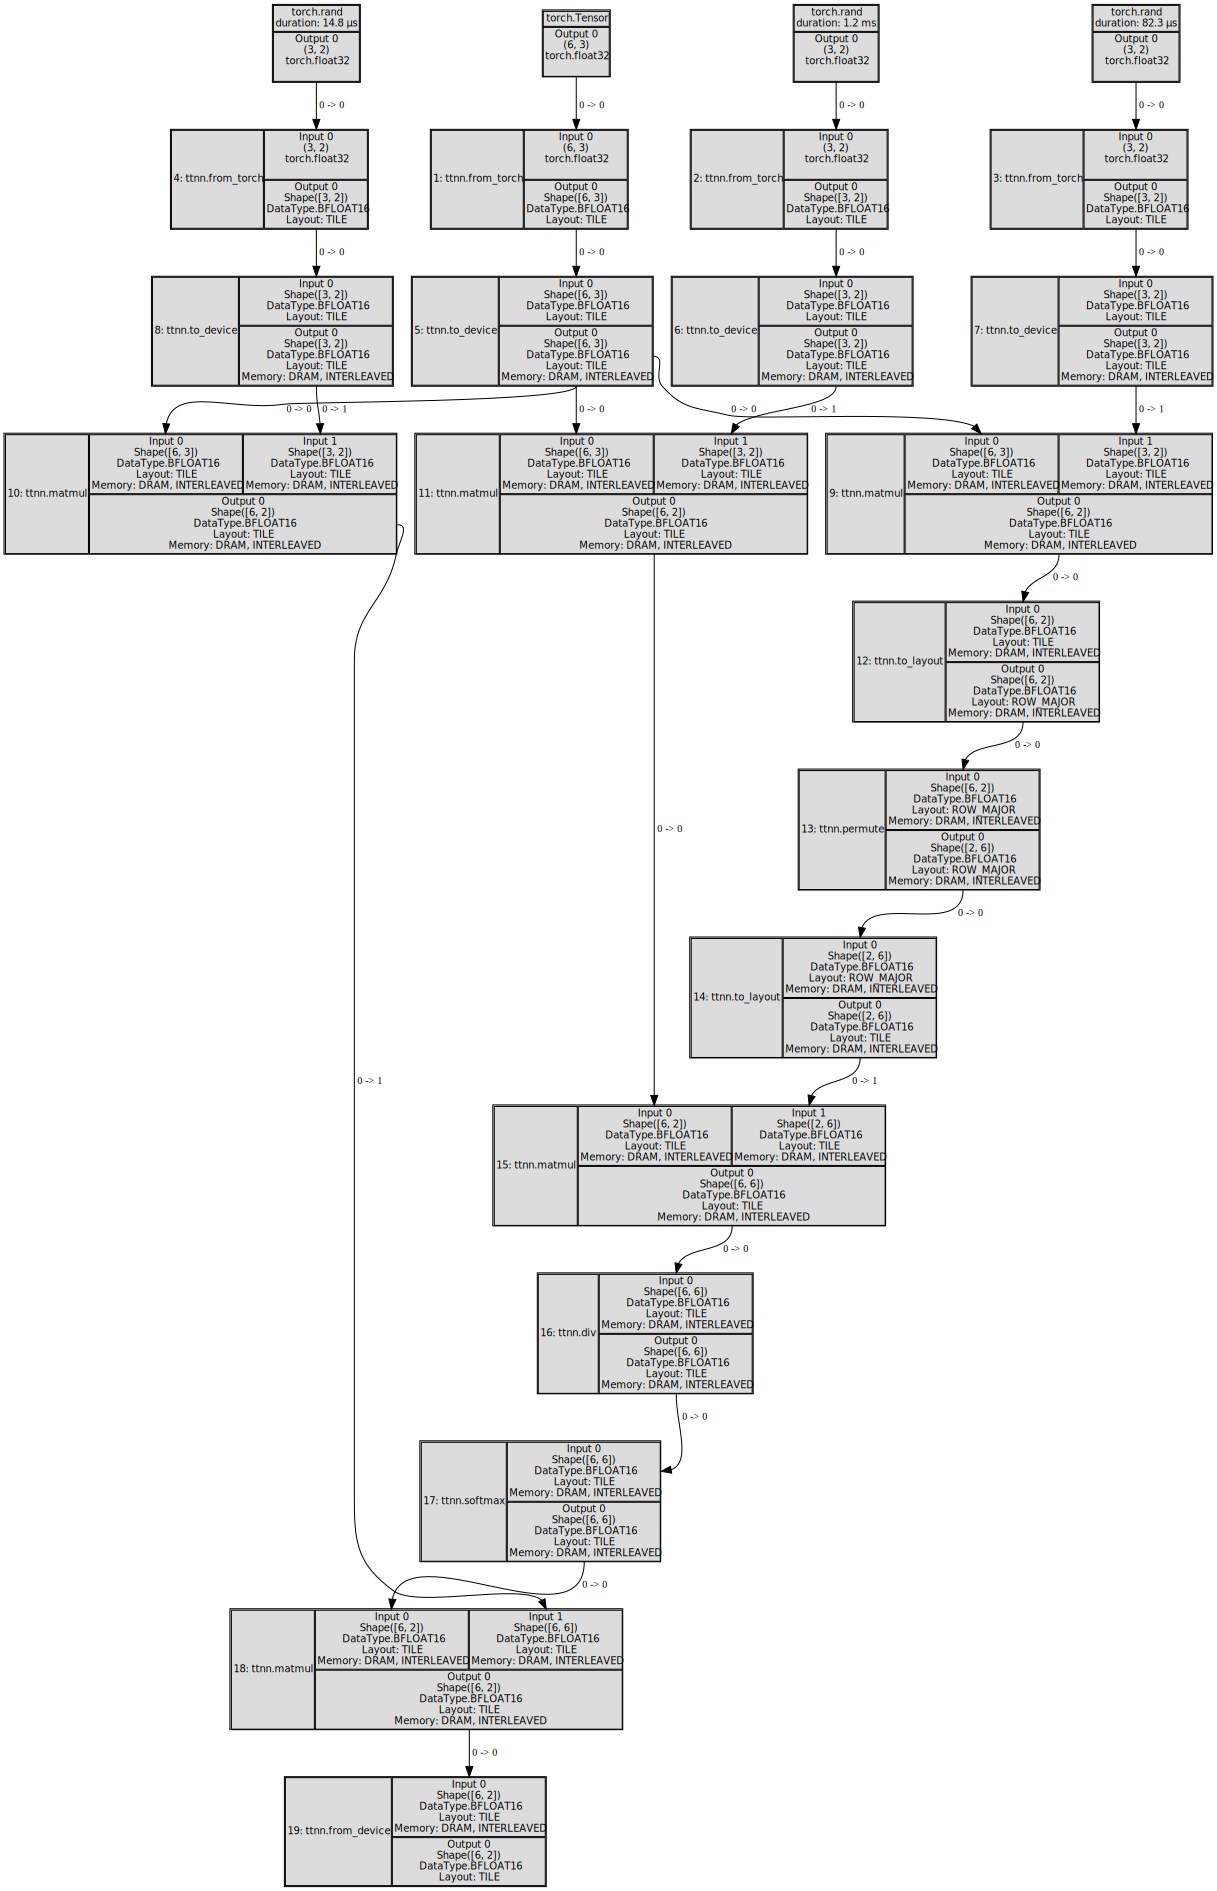

In [5]:
visualize(context_vecs_host_ttnn)

Finally, here are the specific values.

In [12]:
context_vecs_host_ttnn

ttnn.Tensor([[ 0.29688,  0.79688],
             [ 0.30469,  0.81250],
             ...,
             [ 0.28906,  0.78125],
             [ 0.29688,  0.80078]], shape=Shape([6, 2]), dtype=DataType::BFLOAT16, layout=Layout::TILE)